In [1]:
%pylab inline
import cpsutils.kbc
import cpsutils.io
from cpsutils.hires import exposure
import pandas as pd
from astropy.time import Time
import numpy as np
from numpy import nan, arange
import radvel
import sys
sys.path.append("/Users/lweiss/cksphys/")
#sys.path.append("/Users/lweiss/kgps/")
#from rv_sensitivity import *
from mock_up_rvs import *

Populating the interactive namespace from numpy and matplotlib


numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


## Load the planet data

In [2]:
tess_multis = pd.read_csv("../data/tess_multis_planet_candidates.csv")
tess_hosts = tess_multis.groupby('host').first()
for c in tess_multis.columns:
    print(c)

TIC ID
TOI
Master priority
SG1A priority
SG1B priority
SG2 priority
SG3 priority
SG4 priority
SG5 priority
TESS Disposition
TFOPWG Disposition
TESS mag
TESS mag error
# PCs
Source
RA (degrees)
Dec (degrees)
PM RA (mas/yr)
PM RA error
PM Dec (mas/yr)
PM Dec error
Epoch (BJD)
Epoch error
Period (days)
Period error
Duration (hours)
Duration error
Depth (mmag)
Depth (mmag) error
Depth (ppm)
Depth (ppm) error
Planet Radius (R_Earth)
Planet Radius error
Planet Insolation (Earth flux)
Planet Eq Temp (K)
Planet SNR
Stellar Distance (pc)
Stellar Distance error
Stellar Teff (K)
Stellar Teff error
Stellar log(g) (cm/s2)
Stellar log(g) error
Stellar Radius (R_Sun)
Stellar Radius error
Sectors
Comments
Date Created
Date Modified
host
npl


## Mock up RVs

In [3]:
def initialize_model(mystar, vary_ecc=False, num_NT=0,NT_per = 0.0,NT_phase=0.0,NT_per_vary=True):
    ntp = len(mystar['Period (days)'].values) # number of transiting planets
    npl = num_NT + ntp
    
    if vary_ecc==False:
        secw_val = [0.0] * len(mystar)
        sesw_val = [0.0] * len(mystar)
    else:
        secw_val = mystar['secw'].values
        sesw_val = mystar['sesw'].values

    try:
        NT_per = list(NT_per)
        NT_phase = list(NT_phase)
    except:
        NT_per = [NT_per]
        NT_phase = [NT_phase]

    params = radvel.Parameters(npl,basis='per tc secosw sesinw k') # number of planets = npl
    for i, pl in enumerate(mystar.iterrows()):
        params['per'+str(i+1)] = radvel.Parameter(value=pl[1]['Period (days)'],vary=False) # transit-determined period
        params['tc'+str(i+1)] = radvel.Parameter(value=pl[1]['Epoch (BJD)'],vary=False) # transit-determined phase
        params['sesinw'+str(i+1)] = radvel.Parameter(value=sesw_val[i],vary=vary_ecc) # hold eccentricity fixed at 0 for now
        params['secosw'+str(i+1)] = radvel.Parameter(value=secw_val[i],vary=vary_ecc) # hold eccentricity fixed at 0 for now
        params['k'+str(i+1)] = radvel.Parameter(value=pl[1].K, vary=True)   # vary K
    i = ntp
    while i < (npl -1):
        import collections
        if not isinstance(NT_per, collections.Iterable):
            NT_per = [NT_per]
        if not isinstance(NT_phase, collections.Iterable):
            NT_phase = [NT_phase]
        i+=1
        print(i - ntp)
        print(NT_per[i-ntp], NT_phase[i-ntp])
        params['per'+str(i+1)] = radvel.Parameter(value=NT_per[i - ntp],vary=NT_per_vary)
        params['tc'+str(i+1)] = radvel.Parameter(value=t.min() + np.sin(NT_phase[i - ntp] - np.pi/2.)*NT_per[i - ntp])
        params['sesinw'+str(i+1)] = radvel.Parameter(value=0.0,vary=vary_ecc) # hold eccentricity fixed at 0
        params['secosw'+str(i+1)] = radvel.Parameter(value=0.0,vary=vary_ecc)
        params['k'+str(i+1)] = radvel.Parameter(50.)   
    
    mod = radvel.RVModel(params, time_base=500)
    return mod

In [4]:
def mass_ecc_mystar(mystar):
    from numpy import sqrt, sin, cos, pi

    mystar['Mp'] = calc_Mp(mystar['Planet Radius (R_Earth)'].values) # calculate masses using M-R
    mystar['ecc'] = draw_ecc(size=len(mystar))
    w = np.random.uniform(low=0,high=(2*pi),size=len(mystar))
    mystar['secw'] = np.sqrt(mystar['ecc'].values) * cos(w)
    mystar['sesw'] = np.sqrt(mystar['ecc'].values) * sin(w)
    mystar['K'] = radvel.utils.semi_amplitude(mystar.Mp, mystar['Period (days)'], mystar['Stellar Radius (R_Sun)'], mystar.ecc, Msini_units='earth')
    return mystar

def rvmystar(mystar, t, verbose=False):
    mod = initialize_model(mystar, vary_ecc=False)
    try:
        errvel = rverr_photon(mystar['TESS mag'].values[0]+1.0, 600., verbose=verbose)
    except:
        errvel = rverr_photon(mystar['TESS mag'].values[0]+1.0, 1200., verbose=verbose)
    errvel = pow(errvel**2. + 2.0**2., 0.5) # add 2 m/s jitter
    vel = mod(t) + np.random.normal(scale=errvel, size=len(t))
    
    return(t, vel, errvel)

### Now fit the mocked up RVs

In [5]:
def plot_results(like, mystar):
    fig = figure(figsize=(12,4))
    fig = gcf()
    fig.set_tight_layout(True)
    errorbar(
        like.x, like.model(t)+like.residuals(),
        yerr=like.yerr, fmt='o', label='Mock RVs'
        )
    plot(ti, like.model(ti), label='Best-fit Model')
    xlabel('Time (days)')
    ylabel('RV (m/s)')
    title("TOI-"+str(mystar.host.values[0]))
    legend()
    draw()
    
def get_K(mystar,post):
    best_K = []
    for i, pl in enumerate(mystar.iterrows()):
        best_K.append(post.likelihood.params['k'+str(i+1)].value)
    return np.array(best_K)

In [6]:
def goodness_of_RVs(mystar, t, vel, err, vary_ecc=False, plot=False, save=False):
#    mystar = mass_ecc_mystar(mystar)
#    t, vel, errvel = rvmystar(mystar)

    mod = initialize_model(mystar, vary_ecc=vary_ecc)
    like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
    like.params['gamma'] = radvel.Parameter(value=0.0,vary=True)
    like.params['jit'] = radvel.Parameter(value=2.0,vary=False)
    
    # Define prior shapes and widths here.
    npl = len(mystar)
    
    kpriors = [radvel.prior.HardBounds('k'+str(i+1), 0.0, 10.0) for i in range(npl)]
    priors = [
        radvel.prior.EccentricityPrior( npl ),           # Keeps eccentricity < 1
        radvel.prior.HardBounds('jit', 0.0, 10.0),
    ]
    post = radvel.posterior.Posterior(like)
    post.priors += priors
    post.priors += kpriors
    if plot==True:
        print(post)


    from scipy import optimize
    res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='nelder-mead',           # Nelder-Mead also works
    )
    
    if plot==True:
        plot_results(like, mystar)             # plot best fit model
        print(post)
        if save==True:
            savefig("../plots/TOI-"+str(mystar.host.values[0])+"_mock_rvs.png",dpi=180)
            text_file = open("../trials/TOI-"+str(mystar.host.values[0])+"_post.txt", "w")
            text_file.write("%s" % post.__repr__)
            text_file.close()

    true_K = np.array(mystar.K)
    best_K = np.array(get_K(mystar,post))
    return((best_K - true_K)/true_K)


In [7]:
def plot_delta_K(mystar, delta_K):
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['axes.labelsize'] = 14    # fontsize of the x and y labels
    matplotlib.rcParams['axes.titlesize'] = 16    # fontsize of the x and y labels
    fig = figure(figsize=(6,4))
    fig = gcf()
    fig.set_tight_layout(True)

    mean_K_frac = np.mean(delta_K,axis=0)
    sig_K_frac = np.std(delta_K,axis=0)
    for col in range(delta_K.shape[1]):
        hist(delta_K[:,col],alpha=0.5,range=[-1,2],label='$K_%i; K/\sigma_K$=%0.1f' %((col+1),np.round(1./sig_K_frac[col],1)))
    legend()
    ylabel('Number of Trials')
    xlabel('Fractional Change in K')
    title(mystar.id_starname.values[0])
    savefig("../plots/"+str(mystar.host.values[0])+"DeltaK_dist.png", dpi=180)
    

In [8]:
def monte_carlo_delta_K(mystar,t):
    delta_K = []
    for i in range(100):
        t, vel, errvel = rvmystar(mystar, t) # change the RVs
        delta_K.append(goodness_of_RVs(mystar, t, vel, errvel))
    delta_K = np.array(delta_K)
    return delta_K

In [9]:
def plot_delta_K(mystar, delta_K):
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['axes.labelsize'] = 14    # fontsize of the x and y labels
    matplotlib.rcParams['axes.titlesize'] = 16    # fontsize of the x and y labels
    fig = figure(figsize=(6,4))
    fig = gcf()
    fig.set_tight_layout(True)

    mean_K_frac = np.mean(delta_K,axis=0)
    sig_K_frac = np.std(delta_K,axis=0)
    for col in range(delta_K.shape[1]):
        hist(delta_K[:,col],alpha=0.5,range=[-1,2],label='$K_%i; K/\sigma_K$=%0.1f' %((col+1),np.round(1./sig_K_frac[col],1)))
    legend()
    ylabel('Number of Trials')
    xlabel('Fractional Change in K')
    title("TOI-%i"%mystar.host.values[0])
    savefig("../plots/TOI-%i_DeltaK_dist.png"%mystar.host.values[0], dpi=180)
    

## Test one star at a time

150
[175]
      TOI  host  TESS mag  Period (days)  Planet Radius (R_Earth)        Mp  \
9  175.03   175     9.393       2.253014                 0.793986  0.473858   
7  175.01   175     9.393       3.690613                 1.348538  3.173848   
8  175.02   175     9.393       7.451113                 1.434774  3.982099   

          K  
9  0.448068  
7  2.544061  
8  2.533344  
Mag 	 Exptime (s) 	 kCounts 	 RV_err (m/s):
10.4 	 	 600 	 139 	 1.9


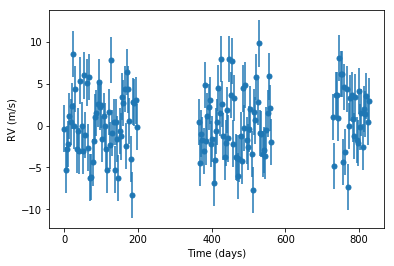

In [10]:
n_per_sum = 60
day_spread = 200./n_per_sum
year = 365
t = np.concatenate([arange(n_per_sum) * day_spread, 1*year + arange(n_per_sum) * day_spread, 2* year + arange(n_per_sum//2) * day_spread])
print(len(t))
ti = arange(min(t),max(t),0.01)
mystars = np.random.choice(np.array(tess_hosts.index), size=1, replace=False)
print(mystars)
cols_of_interest = ['TOI','host','TESS mag','Period (days)','Planet Radius (R_Earth)','Mp','K']
for s in mystars:
    mystar = tess_multis[tess_multis.host==s].sort_values('Period (days)')
    mystar = mass_ecc_mystar(mystar)
    print(mystar[cols_of_interest])
    t, vel, errvel = rvmystar(mystar,t, verbose=True)
    errorbar(t,vel,errvel,fmt='o')
    xlabel('Time (days)')
    ylabel ('RV (m/s)')

parameter                     value      vary
per1                        2.25301      False
tc1                         8354.91      False
secosw1                           0      False
sesinw1                           0      False
k1                         0.448068       True
per2                        3.69061      False
tc2                          8356.2      False
secosw2                           0      False
sesinw2                           0      False
k2                          2.54406       True
per3                        7.45111      False
tc3                         8355.29      False
secosw3                           0      False
sesinw3                           0      False
k3                          2.53334       True
dvdt                              0       True
curv                              0       True
gamma                             0       True
jit                               2      False

Priors
------
e1 constrained to be < 0.99
e2 constrained to 

array([ 0.84648491,  0.14732964, -0.091182  ])

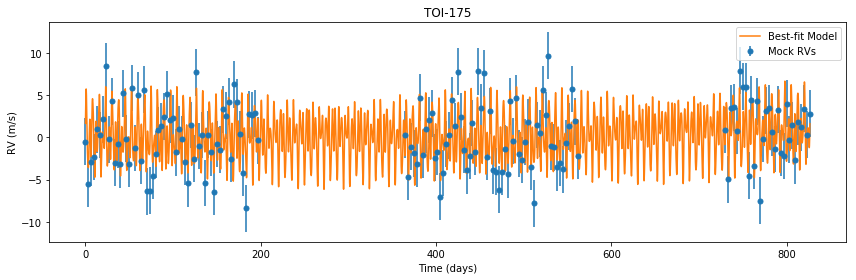

In [11]:
#t, vel, errvel = rvmystar(mystar)
goodness_of_RVs(mystar, t, vel, errvel, vary_ecc=False, plot=True, save=True)

In [12]:
delta_K = monte_carlo_delta_K(mystar,t)

In [27]:
Ksig = 1./delta_K.std(axis=0)
mystar['Ksig'] = Ksig

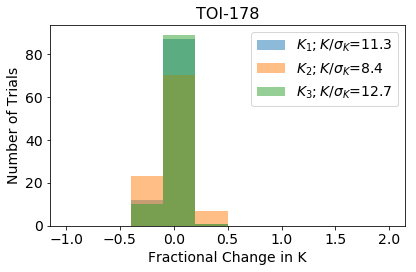

In [22]:
plot_delta_K(mystar,delta_K)

In [28]:
final_cols = list(np.concatenate([cols_of_interest,['Mp','K','Ksig']]))
mystar[final_cols].set_index('TOI').to_csv('../individual_planet_tables/TOI-'+str(mystar.host.values[0])+'_table.csv')
mystar[final_cols].set_index('TOI')

,host,TESS mag,Period (days),Planet Radius (R_Earth),Mp,K,Mp,K,Ksig
TOI,,,,,,,,,
178.01,178,10.351,6.558054,2.773247,6.945950,3.006679,6.945950,3.006679,11.274296
178.03,178,10.351,9.955936,2.323174,5.891261,2.228523,5.891261,2.228523,8.447821
178.02,178,10.351,10.354252,3.751004,9.198340,3.433598,9.198340,3.433598,12.721039


In [29]:
np.save("../trials/TOI-"+str(mystar.host.values[0])+'_delta_K.npy',delta_K)

## Iterate for many stars

In [53]:
def mock_my_star(host):
    print(host)
    n_per_sum = 60
    day_spread = 200./n_per_sum
    year = 365
    t = np.concatenate([arange(n_per_sum) * day_spread, 1*year + arange(n_per_sum) * day_spread, 2* year + arange(n_per_sum//2) * day_spread])
    mystar = tess_multis[tess_multis.host==host].sort_values('Period (days)')
    mystar = mass_ecc_mystar(mystar)
    t, vel, errvel = rvmystar(mystar, t, verbose=True)
    goodness_of_RVs(mystar, t, vel, errvel, vary_ecc=False, plot=True, save=True)
    delta_K = monte_carlo_delta_K(mystar,t)
    Ksig = 1./delta_K.std(axis=0)
    mystar['Ksig'] = Ksig
    plot_delta_K(mystar,delta_K)
    final_cols = list(np.concatenate([cols_of_interest,['Mp','K','Ksig']]))
    mystar[final_cols].set_index('host').to_csv('../individual_planet_tables/TOI-'+str(mystar.host.values[0])+'_table.csv')
    np.save("../trials/TOI-"+str(mystar.host.values[0])+'_delta_K.npy',delta_K)
    return

In [54]:
tess_hosts.index.values

array([119, 125, 174, 175, 178, 216, 256, 270, 402])

119
Mag 	 Exptime (s) 	 kCounts 	 RV_err (m/s):
10.2 	 	 600 	 161 	 1.8
parameter                     value      vary
per1                        5.54174      False
tc1                         8327.61      False
secosw1                           0      False
sesinw1                           0      False
k1                          2.55656       True
per2                        10.6945      False
tc2                         8328.04      False
secosw2                           0      False
sesinw2                           0      False
k2                          2.01351       True
dvdt                              0       True
curv                              0       True
gamma                             0       True
jit                               2      False

Priors
------
e1 constrained to be < 0.99
e2 constrained to be < 0.99
Bounded prior on jit, min=0.0, max=10.0
Bounded prior on k1, min=0.0, max=10.0
Bounded prior on k2, min=0.0, max=10.0

parameter                     val

parameter                     value      vary
per1                        2.25301      False
tc1                         8354.91      False
secosw1                           0      False
sesinw1                           0      False
k1                         0.355418       True
per2                        3.69061      False
tc2                          8356.2      False
secosw2                           0      False
sesinw2                           0      False
k2                          2.60826       True
per3                        7.45111      False
tc3                         8355.29      False
secosw3                           0      False
sesinw3                           0      False
k3                          3.09654       True
dvdt                     0.00311735       True
curv                    4.26632e-06       True
gamma                     -0.184482       True
jit                               2      False

Priors
------
e1 constrained to be < 0.99
e2 constrained to 

parameter                     value      vary
per1                        3.35986      False
tc1                         8387.09      False
secosw1                           0      False
sesinw1                           0      False
k1                          1.83802       True
per2                        5.66021      False
tc2                          8389.5      False
secosw2                           0      False
sesinw2                           0      False
k2                          4.15768       True
per3                        11.3791      False
tc3                         8389.68      False
secosw3                           0      False
sesinw3                           0      False
k3                          3.25916       True
dvdt                    -0.00299797       True
curv                    -2.5898e-06       True
gamma                     -0.593375       True
jit                               2      False

Priors
------
e1 constrained to be < 0.99
e2 constrained to 

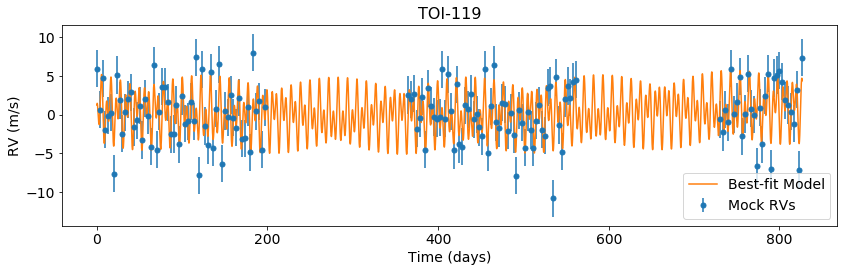

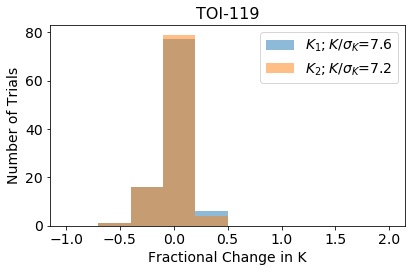

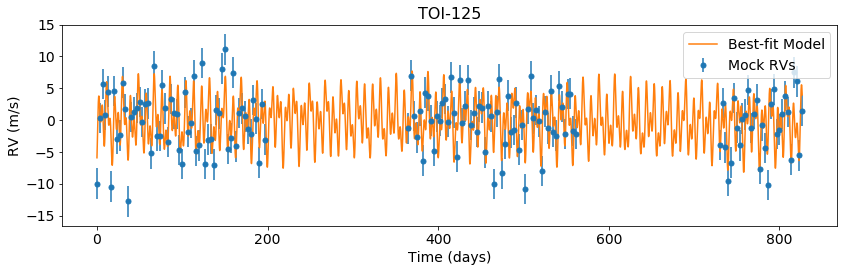

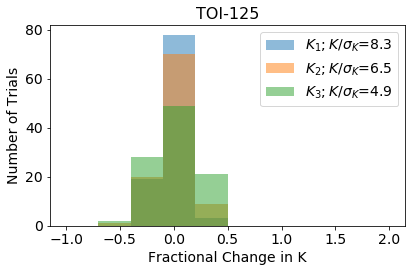

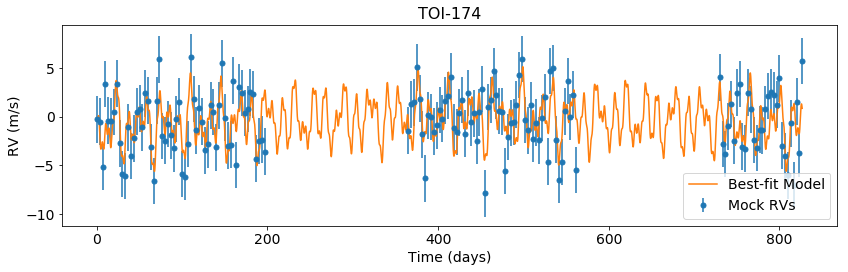

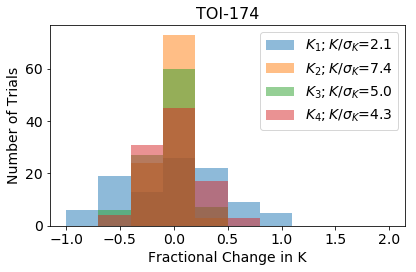

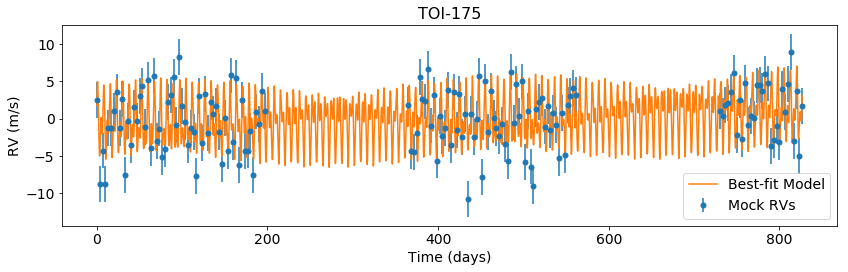

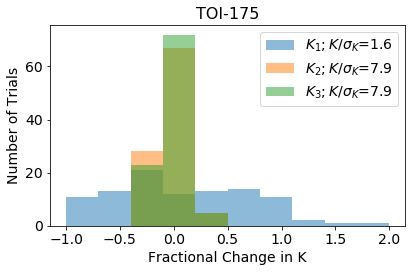

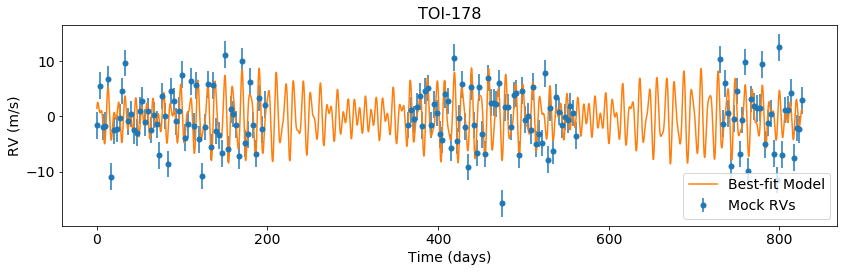

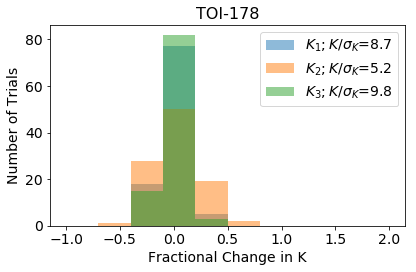

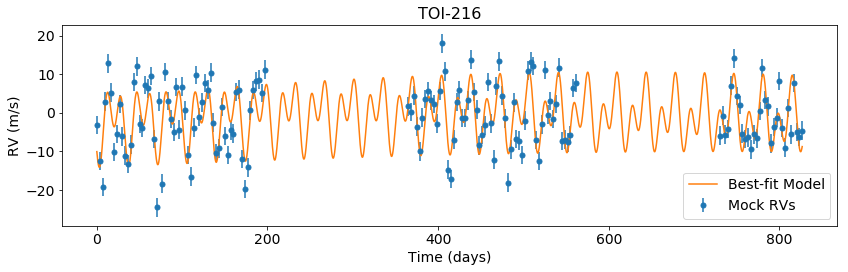

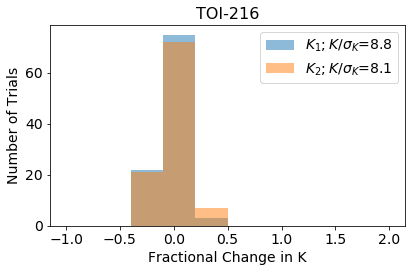

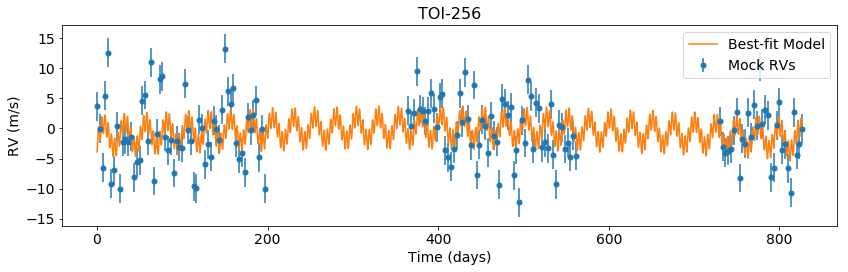

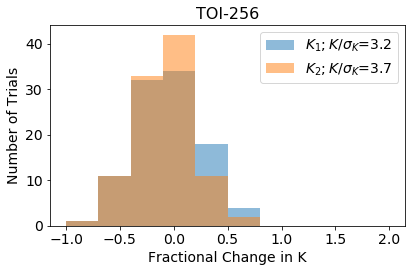

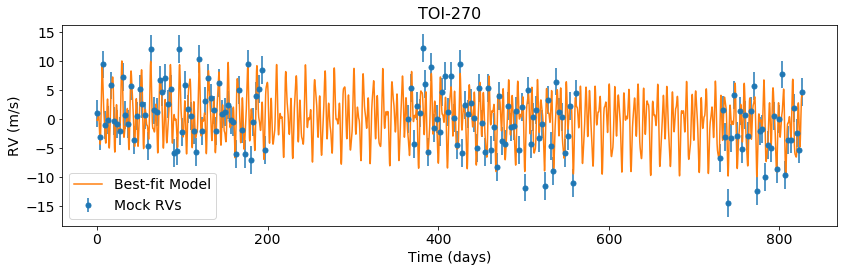

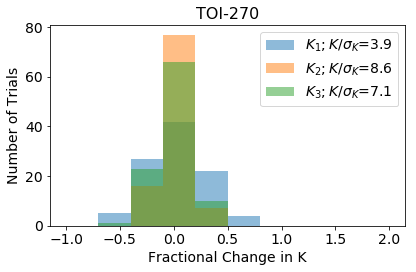

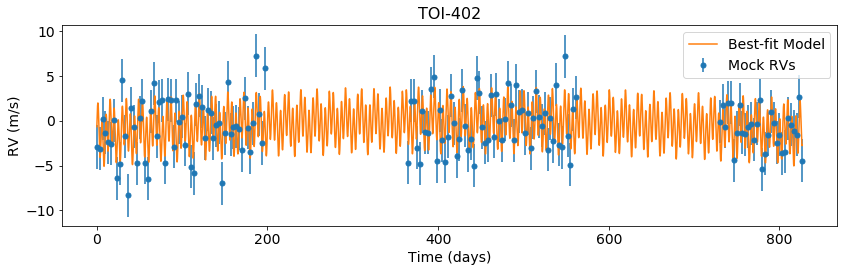

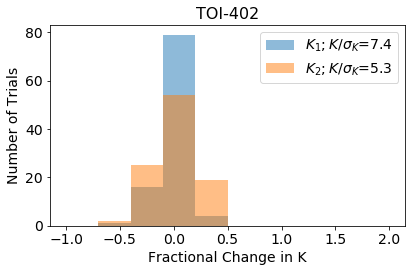

In [55]:
for host in tess_hosts.index.values:
    mock_my_star(host)

(array([0., 0., 0., 1., 2., 4., 0., 3., 2., 4., 1., 4., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

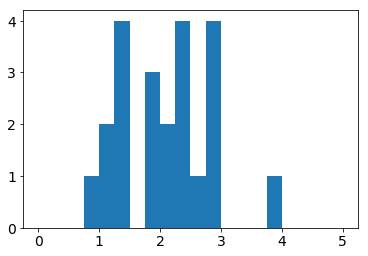

In [50]:
hist(tess_multis['Planet Radius (R_Earth)'],range=[0,5],bins=20)

In [51]:
hist(tess_multis['K'],range=[0,5],bins=20)

KeyError: 'K'